# MAP 512 : Tatouage numérique par code Tardos

In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import scipy.stats

m = 2500 # Taille du tatouage : Fixée par la capacité d'accueil du support (doit être grand pour que les pi suivent bien la distribution)
n = 100000 # Nombre d'utilisateurs : Evolue au fur et à mesure que des utilisateurs se rajoutent
t = 1/300
c = 5 # Taille de la collusion maximale considérée

## Code de Tardos
Cette section propose plusieurs fonctions pour mettre en application la méthode proposée par Tardos.
- *matrice_identifiants* calcule une matrice de $n$ identifiants de taille $m$ par la méthode de Tardos. Les paramètres $p_i$ de Bernouilli de chaque bit de l'identifiant sont tirés selon la loi de densité $f(p) = \frac{Cte}{\sqrt{p(1-p)}}\mathbb{1}_{[t,1-t]}(p)$. On doit donc avoir $t<\frac{1}{2}$.
- *score_tardos* calcule le score de Tardos de l'identifiant $x$ par rapport à $y$ sachant la distribution des $p_i$.

### Calcul de la fonction de répartition de la loi de densité $f$
Le chagement de variable $q=\sqrt{p}$ donne :
$$\int_t^x{f\left(p\right)dp} = \int_t^x{\frac{Cte\cdot dp}{\sqrt{p(1-p)}}} = \int_\sqrt{t}^\sqrt{x}{\frac{Cte\cdot dq}{2\sqrt{(1-q^2)}}} = 2\cdot Cte\left[Arcsin\left(\sqrt{x}\right)-Arcsin\left(\sqrt{t}\right)\right]$$
Donc $Cte = \frac{1}{2\left[Arcsin\left(\sqrt{1-t}\right)-Arcsin\left(\sqrt{t}\right)\right]}$
et la fonction de répartition de cette loi vaut $F(x)=\frac{Arcsin\left(\sqrt{x}\right)-Arcsin\left(\sqrt{t}\right)}{Arcsin\left(\sqrt{1-t}\right)-Arcsin\left(\sqrt{t}\right)}$ sur $[t,1-t]$.  
Puis $F^{-1}(u)=sin^2\left[Arcsin\left(\sqrt{t}\right)+u\cdot\left(Arcsin\left(\sqrt{1-t}\right)-Arcsin\left(\sqrt{t}\right)\right)\right]$.

In [3]:
def matrice_identifiants(n,m,t):
    # On doit avoir t < 0.5
    u = npr.rand(m)
    p = np.sin(np.arcsin(np.sqrt(t)) + u*(np.arcsin(np.sqrt(1-t))-np.arcsin(np.sqrt(t))))
    p = p*p
    X = np.array(npr.binomial(1,p,(n,m)))
    return p,X

def generation_innocents(n,p):
    m = len(p)
    X = np.array(npr.binomial(1,p,(n,m)))
    return X

def score_tardos(x,y,p):
    return np.sum((1-2*(x*(1-y)+y*(1-x)))*((np.sqrt((1-p)/p))**(2*x-1)))

def score_tardos_matrix(X,y,p):
    return np.apply_along_axis(lambda x: score_tardos(x,y,p), axis=1, arr=X)

In [4]:
p,X = matrice_identifiants(n, m, t)
score_tardos(npr.binomial(1,p,m), X[0], p)

-2.9300888937349647

## Monte Carlo naïf pour trouver la p-valeur
Soit $y$ un identifiant trouvé dans une copie pirate et $x$ l'identifiant d'un utilisateur.  
On suppose les $p_i$ connus.  
Quelle est la probabilité $p_x$ qu'un innocent ai un score supérieur à celui de x ?  
Pour répondre à cette question nous utiliserons un estimateur Monte Carlo naïf dans un premier temps:
$$\hat{p_x}=\frac{1}{N}\overset{N}{\underset{k = 1}\sum}{\mathbb{1}_{S\left(X_k\right)\geq S(x)}}\ \ \text{avec}\ \ X_k \overset{iid}{\sim}\left[\mathcal{Bernoulli}(p_i)\right]_{1\leq i\leq m}$$

In [5]:
def MC_naif(N,p,x,y):
    X = np.array(npr.binomial(1,p,(N,m)))
    score = score_tardos_matrix(X,y,p)
    return np.average(score >= score_tardos(x,y,p))

def MC_naif_score(p,score_lim,y,N=1000):
    X = np.array(npr.binomial(1,p,(N,m)))
    score = score_tardos_matrix(X,y,p)
    #print('Var(Score) : '+str(np.average(score**2) - np.average(score)**2))
    return np.average(score >= score_lim)

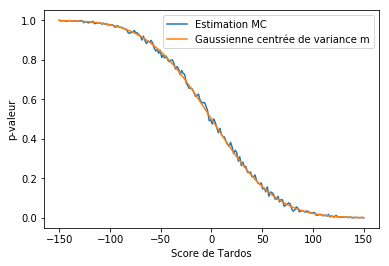

In [37]:
Score = np.linspace(-150,150,200)
Y = npr.binomial(1,p,m)
p_value = []
for score_lim in Score:
    p_value.append(MC_naif_score(p,score_lim,Y))
plt.plot(Score,p_value,label='Estimation MC')
p_value_reel = scipy.stats.norm.sf(Score,0,np.sqrt(m))
plt.plot(Score,p_value_reel,label='Gaussienne centrée de variance m')
plt.xlabel('Score de Tardos')
plt.ylabel('p-valeur')
plt.legend()
plt.savefig("p_valeur_MC_naif.png",dpi=1000)
plt.show()

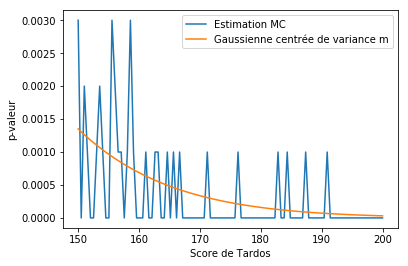

In [38]:
Score = np.linspace(150,200,100)
Y = npr.binomial(1,p,m)
p_value = []
for score_lim in Score:
    p_value.append(MC_naif_score(p,score_lim,Y))
plt.plot(Score,p_value,label='Estimation MC')
p_value_reel = scipy.stats.norm.sf(Score,0,np.sqrt(m))
plt.plot(Score,p_value_reel,label='Gaussienne centrée de variance m')
plt.xlabel('Score de Tardos')
plt.ylabel('p-valeur')
plt.legend()
plt.savefig("p_valeur_MC_naif_zoom.png",dpi=1000)
plt.show()

## Stratégie de la collusion
Nous allons proposer et comparer 3 stratégies pour la collusion :
- *vote_majoritaire* : suit le principe du vote majoritaire
- *entrelacement* : un membre de la collusion est tiré uniformément pour chaque bit
- *pile_ou_face* : à chaque bit repérable par la collusion est attribué la valeur 1 avec probabilité $\frac{1}{2}$
- *vote_minoritaire* : suit le principe du vote minoritaire, tout en suivant la *marking assumption*

Nous rappelons que ces 3 stratégies respectent la *marking assumption* qui stipule : $$\forall i\in[|1,m|]  \ \ X_{1i}=X_{2i}=\cdots=X_{ci}\Rightarrow\rho_{C}(X)_{i} = X_{1i}$$
Avec $C = [|1,c|]$ la collusion et $\rho_C$ leur strategie.

In [6]:
def vote_majoritaire(C):
    return np.round(np.average(C,axis=0))

def entrelacement(C):
    try:
        m = len(C[0])
    except:
        print("Collusion vide")
        return np.array([])
    c = len(C)
    u = npr.randint(low=0, high=c, size=m)
    return C[u,:].diagonal()

def pile_ou_face(C):
    try:
        m = len(C[0])
    except:
        print("Collusion vide")
        return np.array([])
    u = npr.randint(low=0, high=2, size=m)
    mask = C[0] == np.average(C,axis=0)
    for i in range(m):
        if mask[i]:
            u[i] = C[0][i]
    return u
    
def vote_minoritaire(C):
    try:
        m = len(C[0])
    except:
        print("Collusion vide")
        return np.array([])
    u = 1 - np.round(np.average(C,axis=0))
    mask = C[0] == np.average(C,axis=0)
    for i in range(m):
        if mask[i]:
            u[i] = C[0][i]
    return u

In [7]:
C = X[0:3]
vote_majoritaire(C)
entrelacement(C)
pile_ou_face(C)

array([1, 1, 1, ..., 0, 1, 0])

## Distribution empirique des scores des innocents et des colludés
Le but de cette partie est de fournir une repésentation empirique de la distribution des scores des innocents face à une réponse pirate trouvée, et de la comparer à celles des membres de la collusion.  
Cette étude se fait pour les trois stratégies envisagées ci-dessus.

In [7]:
def choix_collusion(X,c):
    C_indices = npr.choice(range(len(X)), size=c, replace=False)
    return C_indices
    
def calcul_marque_pirate(C,strategie):
    return strategie(C)

def prendre_C(indices_collusion,X):
    return X[indices_collusion,:]

def calcul_scores(X,p,c,strategie):
    n = len(X)
    # Choix de la collusion
    C_indices = choix_collusion(X,c)
    C = prendre_C(C_indices,X)
    # Etablissement de la marque pirate
    y = calcul_marque_pirate(C,strategie)
    # Calculs des scores des innocents
    Innocents_indices = list(set(range(n)) - set(C_indices))
    X_innocents = X[Innocents_indices,:]
    Scores_innocents = score_tardos_matrix(X_innocents,y,p)
    # Calcul des scores des colludés
    Scores_colludes = score_tardos_matrix(C,y,p)
    return Scores_innocents,Scores_colludes

def affichage(Scores_innocents,Scores_colludes,nom_strategie):
    plt.hist(Scores_colludes, bins=100, density=True, color='r', label='Colludés')
    # Estimation de la densité par noyau gaussien pour les innocents
    densite_innocents = scipy.stats.gaussian_kde(Scores_innocents)
    x_plot = np.linspace(-200,400,2000)
    plt.plot(x_plot, densite_innocents.evaluate(x_plot), color='g', label='Innocents')
    plt.xlabel('Score de Tardos')
    plt.axvline(x=np.max(Scores_innocents),label="Innocent avec le plus grand score")
    plt.plot(x_plot,scipy.stats.norm.pdf(x_plot,0,np.sqrt(m)),linestyle=':',label="Gaussienne centrée de variance m")
    plt.ylim(0,0.015)
    plt.legend()
    plt.savefig("distribution_innocents_vs_"+nom_strategie+".png",dpi=1000)
    plt.show()
    
def calcul_scores_colludes(X,p,c,strategie):
    n = len(X)
    Scores_colludes = []
    N = 10000
    for k in range(N):
        # Choix de la collusion
        C_indices = choix_collusion(X,c)
        C = prendre_C(C_indices,X)
        # Etablissement de la marque pirate
        y = calcul_marque_pirate(C,strategie)
        # Calcul des scores des colludés
        Scores_colludes.append(score_tardos_matrix(C,y,p))
        if k==0:
            # Calculs des scores des innocents
            Innocents_indices = list(set(range(n)) - set(C_indices))
            X_innocents = X[Innocents_indices,:]
            Scores_innocents = score_tardos_matrix(X_innocents,y,p)
    return Scores_innocents,np.array(Scores_colludes).flatten()

def affichage_colludes(Scores_innocents,Scores_colludes,nom_strategie):
    # Estimation des densités par noyau gaussien
    densite_innocents = scipy.stats.gaussian_kde(Scores_innocents)
    densite_coupables = scipy.stats.gaussian_kde(Scores_colludes)
    mu = np.average(Scores_colludes)
    x_plot = np.linspace(-200,600,2000)
    plt.plot(x_plot, densite_innocents.evaluate(x_plot), color='g', label='Innocents')
    plt.plot(x_plot, densite_coupables.evaluate(x_plot), color='r', label='Colludés')
    plt.xlabel('Score de Tardos')
    plt.axvline(x=np.max(Scores_innocents),label="Innocent avec le plus grand score")
    plt.plot(x_plot,scipy.stats.norm.pdf(x_plot,mu,np.sqrt(m)),linestyle=':',label="Gaussienne de variance m")
    plt.ylim(0,1.25*scipy.stats.norm.pdf(0,0,np.sqrt(m)))
    plt.legend()
    plt.savefig("distribution_innocents_colludes_"+nom_strategie+".png",dpi=1000)
    plt.show()

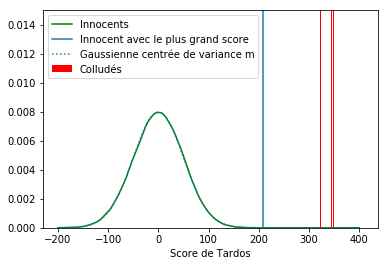

In [12]:
si,sc = calcul_scores(X,p,c,vote_majoritaire)
affichage(si,sc,"vote_majoritaire")

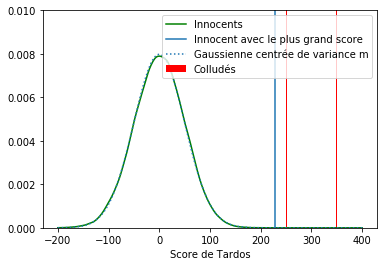

In [10]:
si,sc = calcul_scores(X,p,c,entrelacement)
affichage(si,sc,"entrelacement")

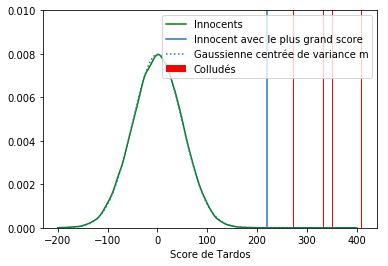

In [11]:
si,sc = calcul_scores(X,p,c,pile_ou_face)
affichage(si,sc,"pile_ou_face")

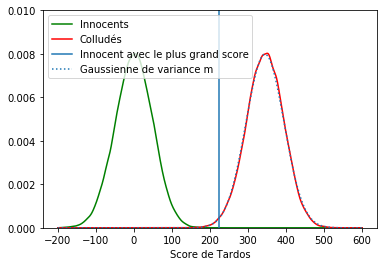

In [12]:
si,sc = calcul_scores_colludes(X,p,c,vote_majoritaire)
affichage_colludes(si,sc,"vote_majoritaire")

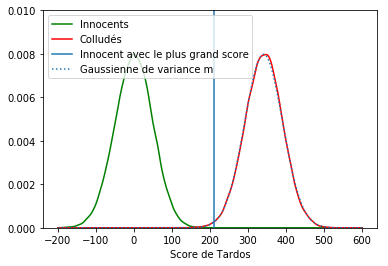

In [13]:
si,sc = calcul_scores_colludes(X,p,c,entrelacement)
affichage_colludes(si,sc,"entrelacement")

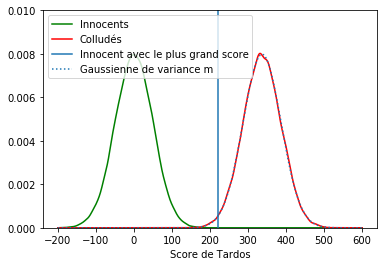

In [14]:
si,sc = calcul_scores_colludes(X,p,c,pile_ou_face)
affichage_colludes(si,sc,"pile_ou_face")

Ici on va faire varier m pour voir le décollement des deux gaussiennes.

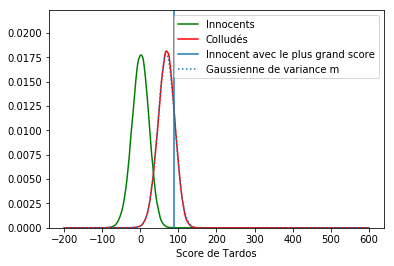

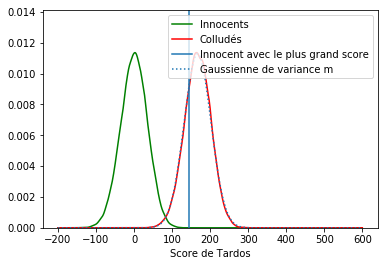

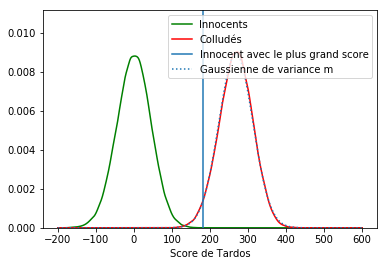

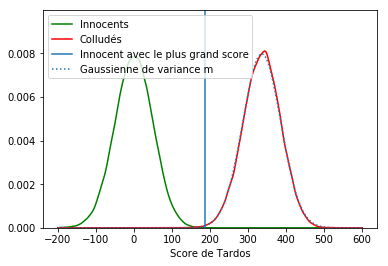

In [9]:
for k in [500,1250,2000,2500]:
    m = k
    p,X = matrice_identifiants(n,m,t)
    si,sc = calcul_scores_colludes(X,p,c,vote_majoritaire)
    affichage_colludes(si,sc,"m_"+str(k))

## Adaptative Multilevel Splitting

In [31]:
def tri_vect(Z):
    # Ordonne le vecteur par score, qui est stocké en première coordonnée
    return np.sort(Z,axis=0)

def clonage(X,Z):
    # Va clonner les tatouages des utilisateurs tirés avec un score inférieur à la médiane 
    #    sur ceux supérieurs à cette dernière
    Z = tri_vect(Z)
    n = len(X)
    pas = int(n/2)
    mediane = Z[pas]['Score']
    for k in range(pas):
        j_1 = Z[k]['Indice']
        j_2 = Z[k+pas]['Indice']
        # Remplace l'utilisateur avec le i-ième score plus bas par le median + i
        X[j_1] = X[j_2].copy()
        Z[k]['Score'] = Z[k+pas]['Score']
    return X,Z,mediane

In [45]:
def etape_MH(X,Z,p,y,J,T):
    X,Z,seuil = clonage(X,Z)
    n = len(X)
    # On fait varier seulement la moitié des joueurs avec les scores les plus faibles
    for t in range(T):
        #compt = 0
        #compt2 = 0
        #delta = 0
        for j in range(int(n/2)):
            # Tirage des J bits du tatouage qui vont changer
            bits_a_changer = npr.choice(m,size=J,replace=False) 
            # Tirage des J bits à changer
            nouveaux_bits = npr.binomial(1,p[bits_a_changer])# aleatoire_k_bit 
            delta_score = (score_tardos(nouveaux_bits,y[bits_a_changer],p[bits_a_changer])
                - score_tardos(X[Z[j]['Indice'],bits_a_changer],y[bits_a_changer],p[bits_a_changer])) 
            # Critère de Metropolis-Hasting pour le rejet
            if(Z[j]['Score'] + delta_score >= seuil):
                #compt += 1
                X[int(Z[j]['Indice']),bits_a_changer] = nouveaux_bits
                #if np.abs(delta_score)==0:
                #   compt2+=1
                #delta += np.abs(delta_score)
                Z[j]['Score'] += delta_score
        #print('Ratio de sauts : '+str(2*compt/n))
        #print('Ratio de sauts statiques : '+str(compt2/(0.01+compt)))
        #print('Ecart moyen : '+str(delta/(0.01+compt)))
    Z = tri_vect(Z)
    nouveau_seuil = Z[int(n/2)]['Score']
    return X,Z,nouveau_seuil           
                
def MC_Adaptative(p,y,score_lim,J,T,N):
    # p est le vecteur des p_i
    # y est la marque pirate
    # score_lim est le score pour lequel on veut calculer la p-value
    # HYPERPARAMETRES:
    # J est la quantite de bits à changer
    # T est la quantite de saut dans l'algorithme de Metropolis-Hasting
    # N le nombre de points pour chaque étape
    X = generation_innocents(N,p)
    S = score_tardos_matrix(X,y,p)
    # Z est le vector des scores avec en deuxième coordonnée l'identifiant (indice de ligne dans X) de l'utilisateur
    Z = np.zeros(N,dtype=[('Score',float),('Indice',int)])
    # Z[i,1] est le i-ème utilisateur dans la liste qui a originé S
    Z['Score'] = S
    Z['Indice'] = range(N)
    Z = tri_vect(Z)
    seuil = Z[len(X)//2]['Score']
    # Stockage de Z pour pouvoir afficher la distribution à la fin
    Z_mem =[Z]
    print(seuil)
    i = 0
    boucle = 0
    mem_seuil = seuil
    while (seuil<score_lim):
        X,Z,seuil = etape_MH(X,Z,p,y,J,T)
        #plt.hist(Z['Score'], bins=100, density=True)
        #plt.show()
        print(seuil)
        Z_mem.append(Z)
        i += 1
    # On a donc depasser le seuil
    # On va maintenant corriger la dernière probabilité
    p_final = np.average(Z['Score'] >= score_lim)
    return (1/2)**(i)*p_final

In [46]:
J = 5
T = 20
N = 1000
Y = npr.binomial(1,p,m)
p_valeur = MC_Adaptative(p,Y,200,J,T,N)
p_valeur_reelle = scipy.stats.norm.sf(200,0,np.sqrt(m))
print(p_valeur)
print(p_valeur_reelle)

1.677556373993621
35.15209840060024
57.6320138149186
73.35043753501972
89.54149912004011
102.21688816936678
113.44536567393324
123.99611305062525
135.00092039907605
145.11314806416962
154.53724573987546
163.12226015451682
171.06507243153214
178.35840095963457
185.14102832117393
192.41465992722064
199.24014825192813
205.75998244769139
7.2021484375e-06
3.167124183311986e-05


0.1756445393530015
35.70890276325107
56.07856848595877
74.99235432593207
93.51797507524465
109.70728607533417
121.78771379769368
132.3616582142748
141.35530754110417
149.89270825184593
157.85587472624474
1.398287803985836
34.66966422530767
57.66201445720469
78.03647374607992
95.38327940019177
108.83724135383
120.68385945739517
130.63030016794764
139.58743918435732
148.24646722009834
156.22257175786962
1.391576175404019
35.04378190357758
57.898018586530696
77.52090363433663
91.93215051913526
107.41123828892141
121.10610368750103
134.16738365560371
145.28761355669576
154.81872639561715
-0.8115728268973816
33.97865255123417
59.93043362831201
77.43714139842855
92.63023275641648
104.59325506510437
116.58205298779838
128.54302958372398
139.21133228614462
148.0814922659402
157.1805018176683
-1.2526347026960138
31.81992911752993
58.258048327703726
81.15506356749765
96.45879686044091
108.79059598598997
120.49790659122581
131.8647139588408
141.16845328794315
150.02633834566086
158.1948275977634


138.20168918213542
147.67229928530568
156.59167190305953
164.63450622801892
172.18391664770053
-0.16904431437011347
35.32511645066707
58.23509966680616
79.20108779859243
95.74901110095568
111.4980990966356
125.92447186391726
138.17717673453222
149.08475880061846
158.8937130991169
169.00256745181832
177.03110851814478
0.3680140369263327
33.385019569472625
58.36478491297829
78.25972183349384
94.52631304372072
107.13494074439906
118.19016284511632
129.65127882159706
139.71709985674963
150.42470593207355
161.2798125763818
171.01047250273785
0.7077560184212714
37.253501861836014
60.687637468141546
79.65002226076086
94.8510364174656
109.65313061619953
121.2260540522005
133.122173286517
143.26859990940764
151.58251392291655
159.67333171437437
167.99566744904462
175.2871601192366
-2.4524590326410287
31.742553367762444
56.577496148323505
73.68489959344602
90.54554023788845
105.99623764362988
120.37828415987195
130.93596513257424
140.63702457731137
149.69263081315896
157.62428896785025
165.90459

119.69113550226787
137.38811858247163
151.70999931224435
162.5966314085778
171.84066545185917
180.0391610972843
187.76778718353916
-1.6436042550035594
33.01924873279796
56.58570380674258
77.42060320754203
98.21516200966109
115.4367647784367
128.83102911412138
140.85334292006914
150.89600178035545
159.89890774758814
168.34079342620853
176.27163594815232
184.12494385288596
191.23637383537155
-1.113096310844604
34.151461605266604
56.96202611830114
76.19216980509307
95.81969531958543
113.28619976880364
126.66604160515047
137.63642784695287
147.0182971025688
155.73803634243785
164.2982832291554
172.626230501536
179.7340798271188
187.1190013327678
-1.5443404746447413
31.39194970864912
57.27349997261732
74.85511264744166
89.63519247820376
102.24527657727756
114.77832153586027
126.0417337850606
136.1700570557752
145.6473704497405
153.42962496017606
160.9028127006695
168.33747566733777
176.13395398634736
183.0875952344537
190.09026489966885
2.6907187500385046
34.68496692027725
58.48950240506654

77.74399880060719
92.06421669423116
106.36480916175486
118.54522883589472
130.16918561951127
139.84161201370455
149.10355227523553
156.76885948784738
165.3580675578741
172.5000024761926
179.92392559218518
187.24878750256494
193.79286960274192
200.12406949142124


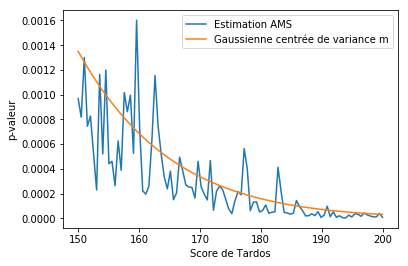

In [49]:
Score = np.linspace(150,200,100)
Y = npr.binomial(1,p,m)
p_value = []
for score_lim in Score:
    print('Score limite : '+str(score_lim))
    p_value.append(MC_Adaptative(p,Y,score_lim,J,T,N))
plt.plot(Score,p_value,label='Estimation AMS')
p_value_reel = scipy.stats.norm.sf(Score,0,np.sqrt(m))
plt.plot(Score,p_value_reel,label='Gaussienne centrée de variance m')
plt.xlabel('Score de Tardos')
plt.ylabel('p-valeur')
plt.legend()
plt.savefig("p_valeur_AMS_zoom.png",dpi=1000)
plt.show()

Score limite : -150.0
0.7519484482730832
Score limite : -146.96969696969697
-1.738098277799864
Score limite : -143.93939393939394
0.39463391429272576
Score limite : -140.9090909090909
0.7905548028716005
Score limite : -137.87878787878788
-0.5344860109960567
Score limite : -134.84848484848484
1.5915800150016786
Score limite : -131.8181818181818
3.719770561024852
Score limite : -128.78787878787878
1.3629758754287131
Score limite : -125.75757575757575
0.9142400275449525
Score limite : -122.72727272727272
2.143504414704095
Score limite : -119.69696969696969
0.8946397235177521
Score limite : -116.66666666666666
0.01148190270308902
Score limite : -113.63636363636364
0.04737400527793767
Score limite : -110.60606060606061
-0.9805047713308657
Score limite : -107.57575757575758
1.7221299101729173
Score limite : -104.54545454545455
1.4400034466278484
Score limite : -101.51515151515152
3.220195047232547
Score limite : -98.48484848484848
0.6977491202961108
Score limite : -95.45454545454545
0.605137

120.47379723522654
131.5297735889382
141.77845236782665
Score limite : 143.93939393939394
-1.2239993704128
31.372273379861067
56.9264958348157
75.87696943692879
94.1589175364281
110.07002913717808
124.65328909838084
138.19942739200252
151.1193048155764
Score limite : 146.96969696969694
2.9439894946250718
35.81235975641854
60.72633181667173
80.06110299890314
98.0253549582188
113.49455937389095
125.86712110739215
135.6500385424275
146.21814720501135
156.36553219733386
Score limite : 150.0
-1.2525002256537014
33.39304205665934
56.97755110836097
75.41910625210048
92.54828544086125
106.8801337592979
119.02390846848238
128.44527772348002
136.78175561117445
144.160943576965
152.2418394120544


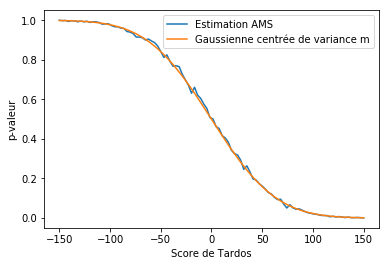

In [48]:
Score = np.linspace(-150,150,200)
Y = npr.binomial(1,p,m)
p_value = []
for score_lim in Score:
    print('Score limite : '+str(score_lim))
    p_value.append(MC_Adaptative(p,Y,score_lim,J,T,N))
plt.plot(Score,p_value,label='Estimation AMS')
p_value_reel = scipy.stats.norm.sf(Score,0,np.sqrt(m))
plt.plot(Score,p_value_reel,label='Gaussienne centrée de variance m')
plt.xlabel('Score de Tardos')
plt.ylabel('p-valeur')
plt.legend()
plt.savefig("p_valeur_AMS.png",dpi=1000)
plt.show()